In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Load the CSV dataset
csv_path = "processed_gauge_train.csv"
image_folder = r"dataset\train"  # Folder containing gauge images

IMG_SIZE = 224  # Image size for MobileNetV2
BATCH_SIZE = 32
EPOCHS = 20
FINE_TUNE_EPOCHS = 10
LEARNING_RATE = 1e-5  # Lower learning rate for fine-tuning

# Load dataset
data = pd.read_csv(csv_path)

# Helper function to load images and preprocess them
def load_images_and_labels(data, image_folder, target_column):
    images = []
    labels = []
    for _, row in data.iterrows():
        img_path = os.path.join(image_folder, row["image_id"])
        img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
        labels.append(row[target_column])
    return np.array(images), np.array(labels)

# Load images and labels
target_column = "gauge_value"  # Use "needle_angle" for angle prediction
X, y = load_images_and_labels(data, image_folder, target_column)

# Normalize target labels (gauge values) to [0, 1] range
max_value = y.max()
y = y / max_value  # Normalize gauge values

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Augment the data
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode="nearest"
)

# Build the MobileNetV2 Model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(128, activation="relu")(x)  # Fully connected layer
x = Dropout(0.3)(x)  # Add dropout to prevent overfitting
output = Dense(1, activation="linear")(x)  # Output layer for regression

model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss="mean_squared_error", metrics=["mae"])

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS
)

# Unfreeze the base model layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="mean_squared_error", metrics=["mae"])

# Fine-tune the model
history_fine_tune = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=FINE_TUNE_EPOCHS
)


C:\Users\sskin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.6708 - mae: 0.6202 - val_loss: 0.2793 - val_mae: 0.4377
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 693ms/step - loss: 0.8308 - mae: 0.7995 - val_loss: 0.2849 - val_mae: 0.4557
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 696ms/step - loss: 0.4015 - mae: 0.5268 - val_loss: 0.2362 - val_mae: 0.4008
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 529ms/step - loss: 0.6082 - mae: 0.6055 - val_loss: 0.3655 - val_mae: 0.5370
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 524ms/step - loss: 0.3773 - mae: 0.4663 - val_loss: 0.1144 - val_mae: 0.2563
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - loss: 0.2485 - mae: 0.3816 - val_loss: 0.1162 - val_mae: 0.2556
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 512ms/step - loss: 0.1449 - mae: 0.3254 - val_loss: 0.1694 - val_mae: 0.3620
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 520ms/step - loss: 0.1458 - mae: 0.2973 - val_loss: 0.1225 - val_mae: 0.3098
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - loss: 0.1338 - mae: 0.2

In [6]:
# Save the trained model
model.save("mobilenetv2_gauge_reader.h5")

In [7]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the trained model
model = load_model("mobilenetv2_gauge_reader.h5")

# Path to a test image
test_image_path = "test_image.jpg"

# Preprocess the test image
img = load_img(test_image_path, target_size=(224, 224))  # Resize to model's input size
img_array = img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict gauge value
prediction = model.predict(img_array)
predicted_value = prediction[0][0] * max_value  # Denormalize
print(f"Predicted Gauge Value: {predicted_value}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
Predicted Gauge Value: 33.40414003993863


In [8]:
import tensorflow as tf

# Load the trained Keras model
model = tf.keras.models.load_model("mobilenetv2_gauge_reader.h5")

# Convert the model to TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable optimization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Optionally, provide a representative dataset for better quantization
def representative_dataset():
    for _ in range(100):  # Replace with the number of samples you want to use
        sample_input = tf.random.normal([1, 224, 224, 3])  # Replace with your actual image data
        yield [sample_input]

converter.representative_dataset = representative_dataset

# Specify supported data types (e.g., 8-bit integers for full quantization)
converter.target_spec.supported_types = [tf.float16]

# Convert the model
tflite_model = converter.convert()

# Save the quantized TFLite model
with open("mobilenetv2_gauge_reader_quantized.tflite", "wb") as f:
    f.write(tflite_model)

print("Quantized TFLite model saved as 'mobilenetv2_gauge_reader_quantized.tflite'")


INFO:tensorflow:Assets written to: C:\Users\sskin\AppData\Local\Temp\tmp_sexeu0r\assets


INFO:tensorflow:Assets written to: C:\Users\sskin\AppData\Local\Temp\tmp_sexeu0r\assets


Saved artifact at 'C:\Users\sskin\AppData\Local\Temp\tmp_sexeu0r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1258073927952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1256375899088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1256375904848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1256375898896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1256375898320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1256375904272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1258075198224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1258075197840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1258075198416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1258075198992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125807

In [9]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="mobilenetv2_gauge_reader_quantized.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess an image
def preprocess_image(image_path, input_size):
    # Open the image file
    img = Image.open(image_path).convert("RGB")
    # Resize the image to the expected size
    img = img.resize((input_size, input_size))
    # Convert to numpy array and normalize to [0, 1]
    img_array = np.array(img).astype(np.float32) / 255.0
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the test image
image_path = "test_image.jpg"

# Preprocess the image
input_size = input_details[0]['shape'][1]  # Assuming square input like 224x224
preprocessed_image = preprocess_image(image_path, input_size)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], preprocessed_image)

# Run inference
interpreter.invoke()

# Get the output tensor
output = interpreter.get_tensor(output_details[0]['index'])

# Print the prediction (denormalize if the model outputs normalized values)
max_value = 100  # Replace with your actual max_value if used
predicted_value = output[0][0] * max_value
print(f"Predicted Gauge Value: {predicted_value}")


Predicted Gauge Value: 19.34984016418457


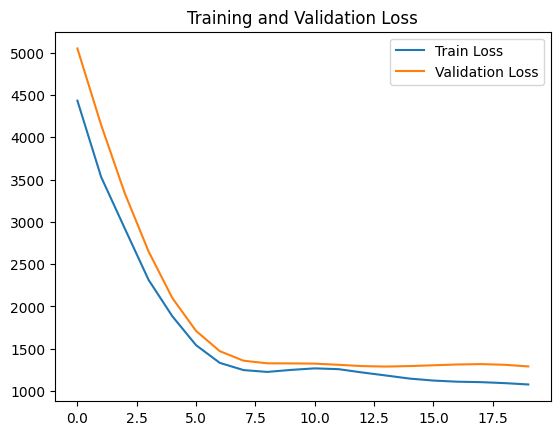

In [7]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()